# Imports and setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np


## Import local settings and liabraries

In [2]:
import spitbran_config
from lib import my_sys_utilities
from lib import my_nc_utilities
from lib import my_plot_utilities
from lib import my_debug_utilities


## Get current working directory

In [3]:
cwd = my_sys_utilities.get_cwd()


## Reload modules (comment for performance, uncomment for development i.e. when editing the modules)

# Get target date and variable and set defaults

In [4]:
target_date = my_sys_utilities.get_target_date(
    "20130101",
    "YYYYMMDD",
)
target_var = my_sys_utilities.get_target_var(
    "thetao",
)


## For each type of data (c or m)

   - load netCDF file and get the values for var

   - plot the maps

re.compile('^[^\\d]{5}_tem-.*_20130101[^()]*\\.nc$')
--------------------
min value depth 0:  12.366570472717285
(array([51]), array([95]))
Coordinates of minimum value depth 0: [(44.020832, 10.041667)]
--------------------
max value: depth 0 15.891289710998535
(array([2]), array([135]))
Coordinates of maximum value depth 0: [(41.979168, 11.708333)]
--------------------
min value depth 1:  12.366621017456055
(array([51]), array([95]))
Coordinates of minimum value depth 1: [(44.020832, 10.041667)]
--------------------
max value: depth 1 15.891300201416016
(array([2]), array([135]))
Coordinates of maximum value depth 1: [(41.979168, 11.708333)]
--------------------
min value depth 0:  5.528642177581787
(array([279]), array([502]))
Coordinates of minimum value depth 0: [(44.064842, 9.988281)]
--------------------
max value: depth 0 16.8630428314209
(array([190]), array([330]))
Coordinates of maximum value depth 0: [(43.36953, 8.644531)]
--------------------
min value depth 1:  5.535002708

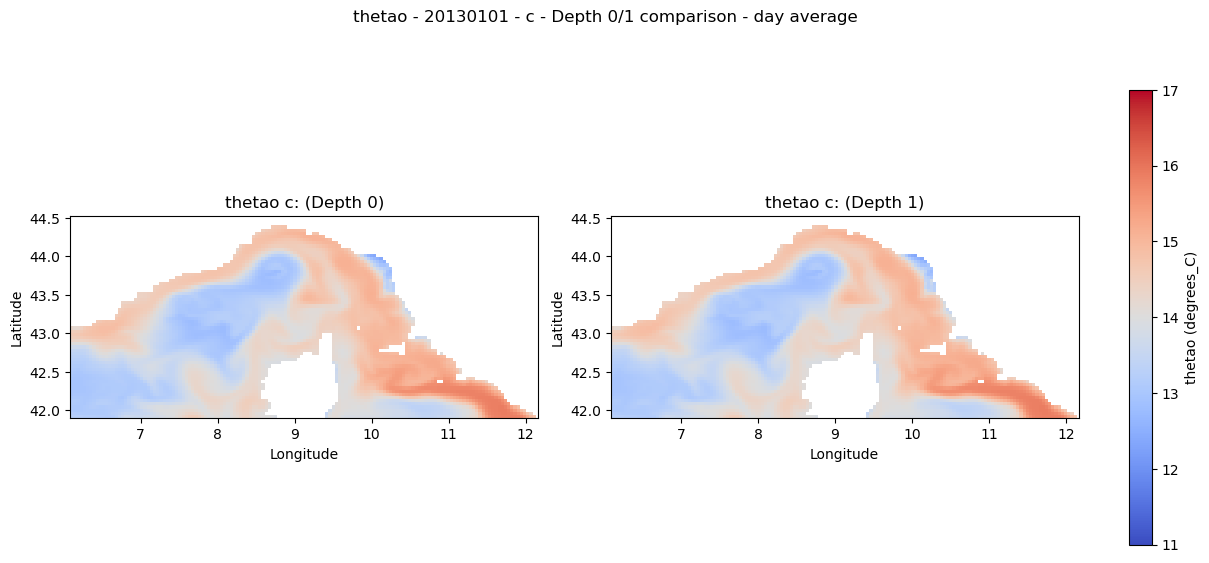

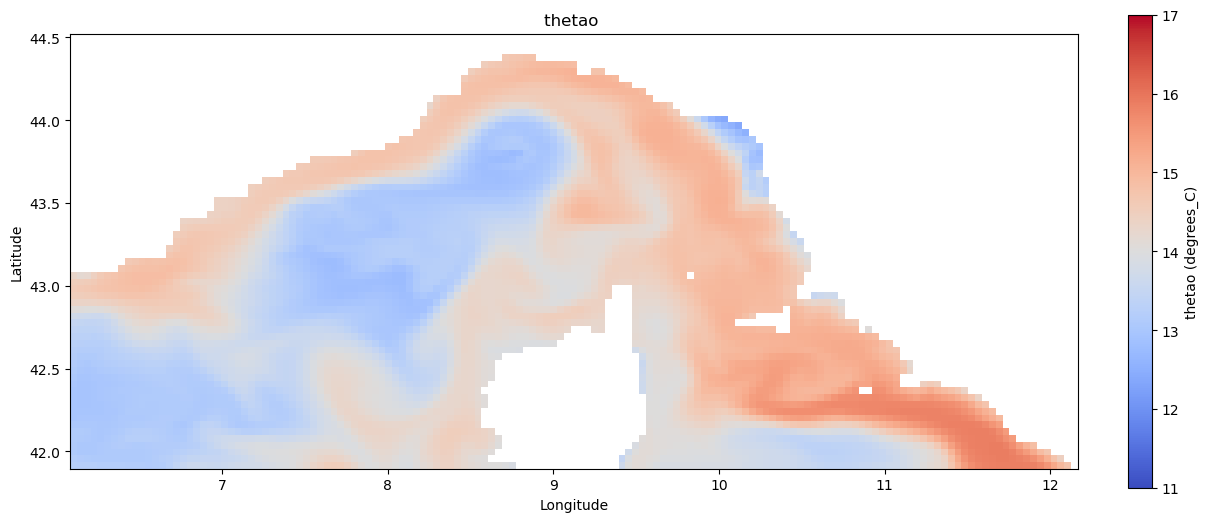

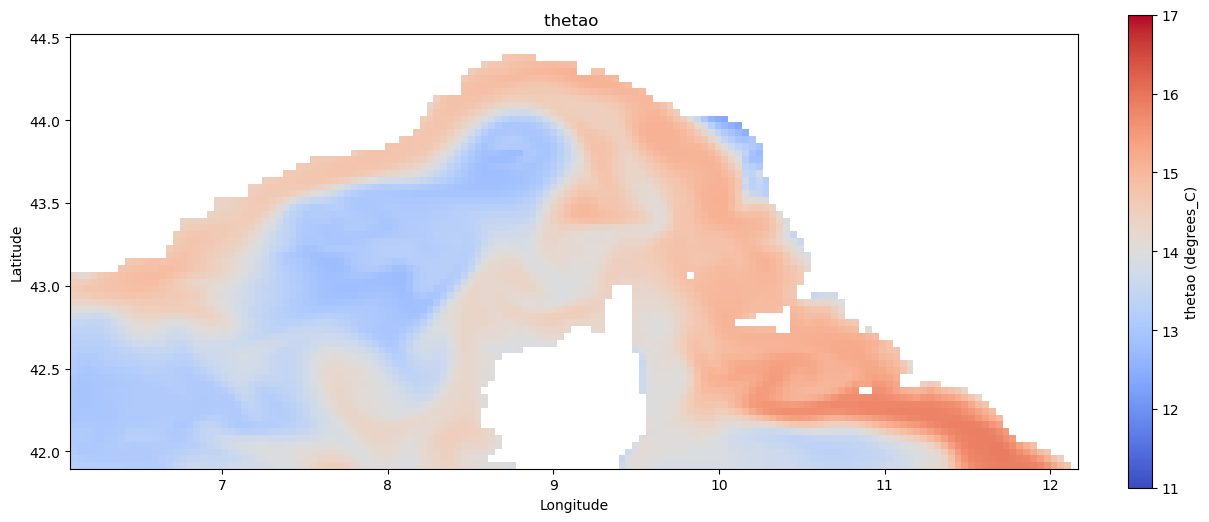

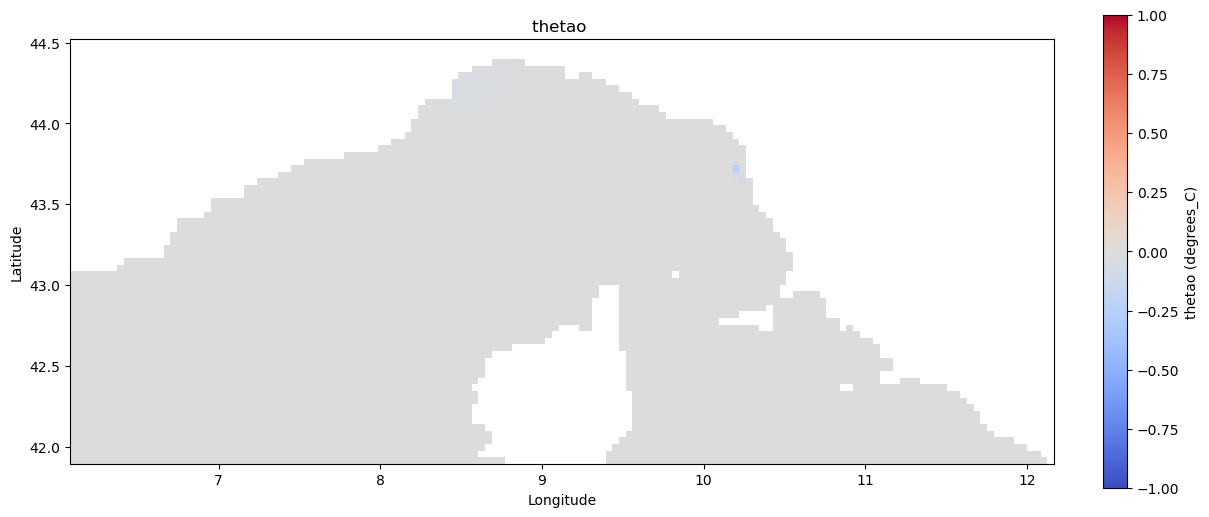

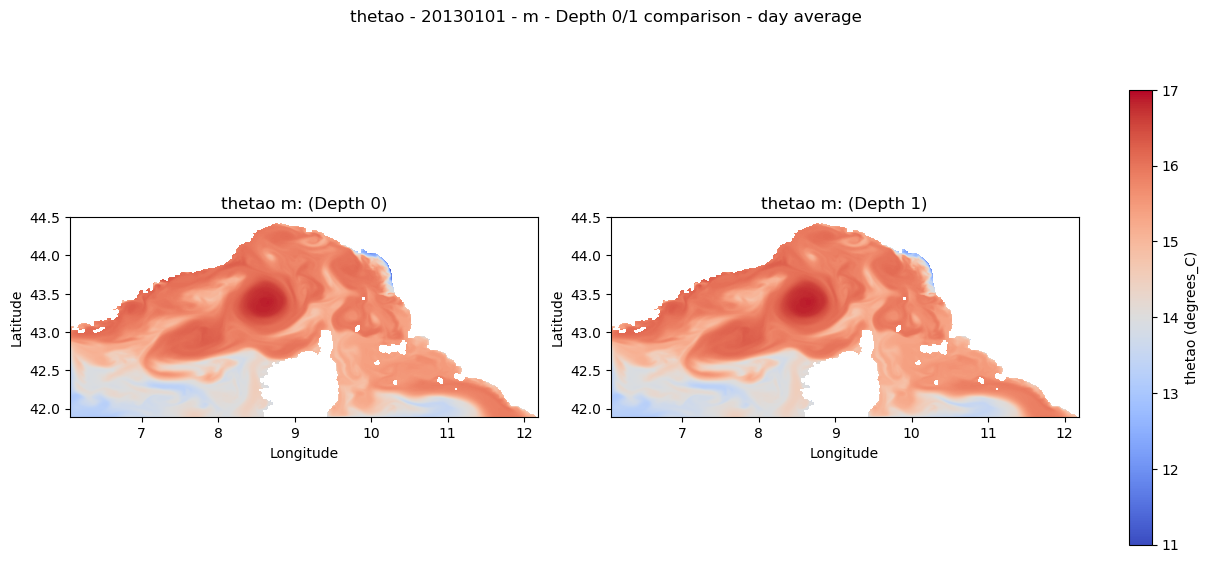

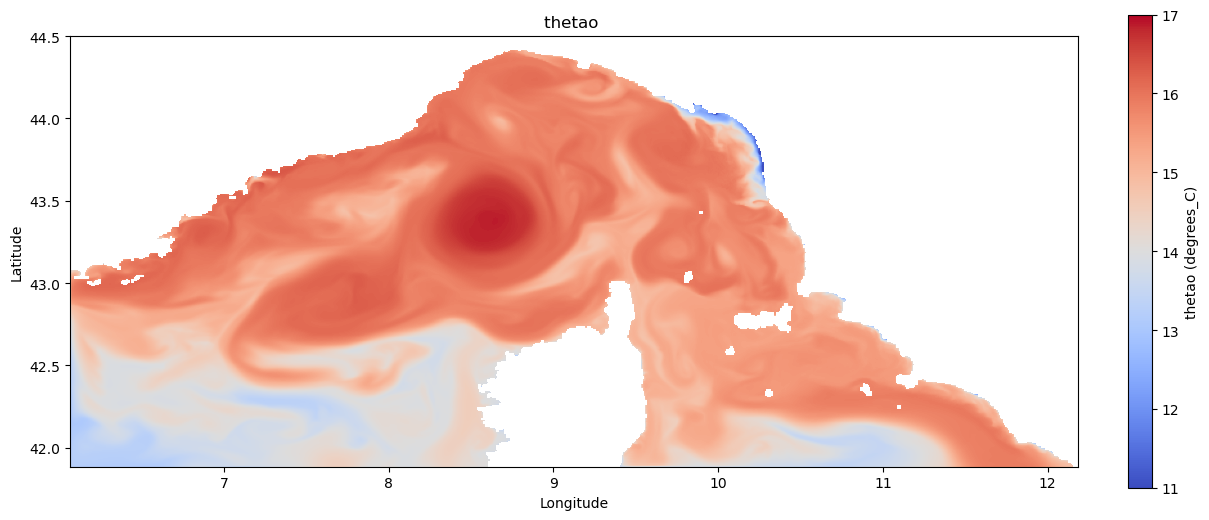

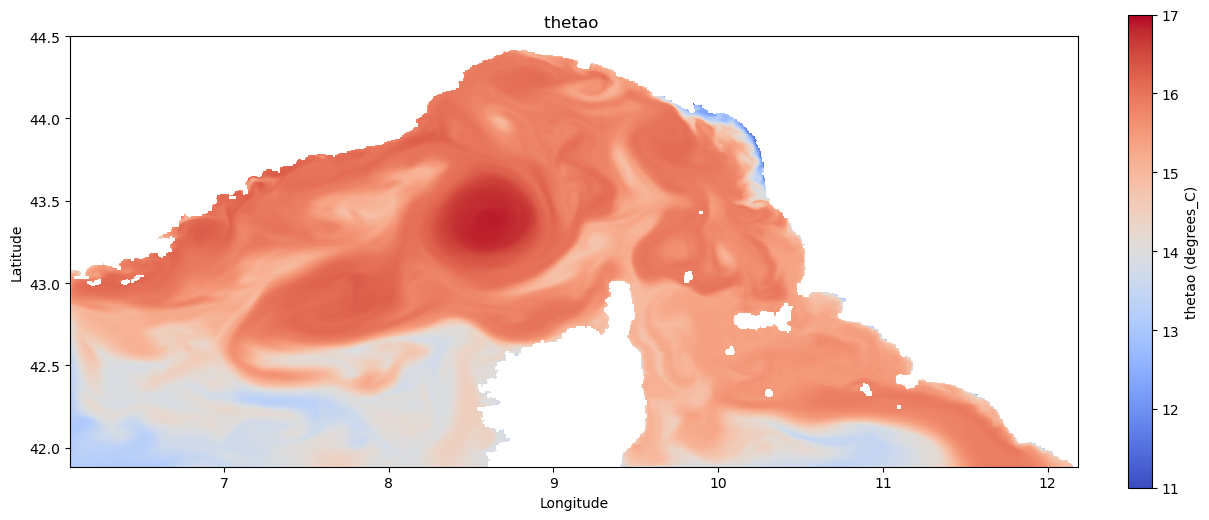

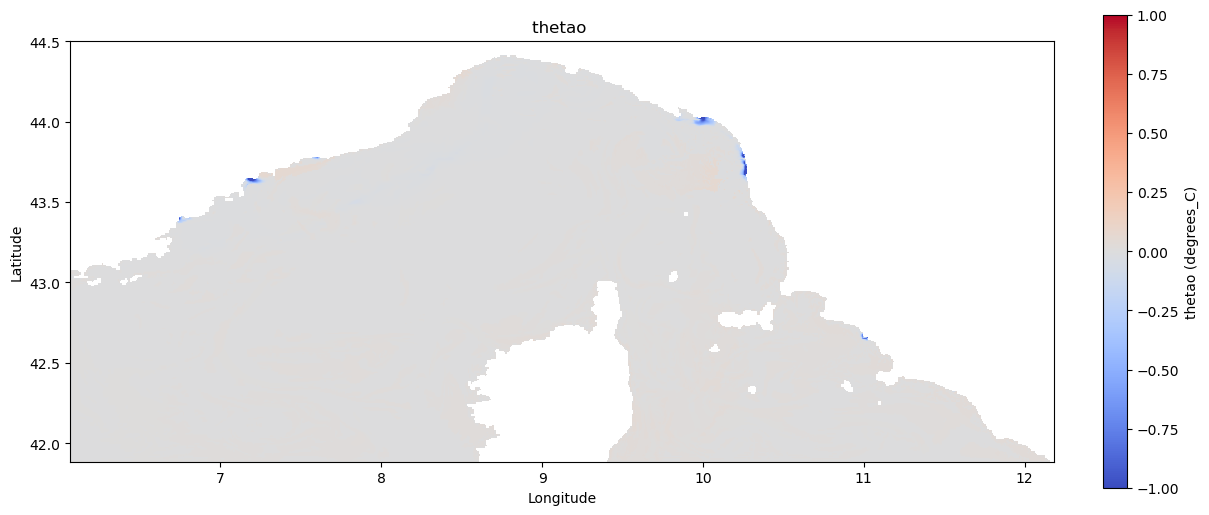

In [5]:
target_var_fn_mapped = {}
for data_type in spitbran_config.cfg_data_base_dirs.keys():

    # Map the target variable to corresponding variable names in CMEMS and MITgcm-BFM file names
    target_var_fn_mapped[data_type] = spitbran_config.cfg_var_filename_map[target_var][data_type]

    # Load NetCDF file
    ds = my_nc_utilities.get_values_map_specific_day(
        data_type,
        spitbran_config.cfg_data_base_dirs[data_type],
        target_date,
        target_var_fn_mapped[data_type],
    )

    # Extract var data at depth indices 0 and 1
    # print(ds.variables.keys())
    # print(ds.variables[target_var].dimensions)
    # ('time', 'depth', 'latitude', 'longitude')
    #   - depth is the second dimension in the dataset
    #   - in the case of MITgcm-BFM, the data gets avaraged over the time dimension 
    #     (in cmems case of CMEMS this is irrelevant as there is only one measurement per day)
    var_d0 = ds.variables[target_var][:, 0, :, :].mean(axis=0)
    var_d1 = ds.variables[target_var][:, 1, :, :].mean(axis=0)
    # Interpolate data of output between depth 0 and depth 1
    #   ds.variables['depth'][:]
    #   0.75 m (first layer i.e. with depth index 0) and
    #   2.25 m (second layer i.e. with depth index 1)
    #   assuming linear interpolation
    # itp_factor = (1.01 - 0.75) / (2.25 - 0.75)
    # var_itp = (1 - itp_factor) * var_d0 + itp_factor * var_d1

    # Extract latitude and longitude
    lat = ds.variables['latitude'][:]
    lon = ds.variables['longitude'][:]

    # Determine the range for the color bar scale 
    #   During development phase take min values across layers to gather the significant range after which values are set to fixed values in the config file (spitbran_config)
    #   Prefer fixed values so that different plots at differnt times can be compared against the same range
    # var_min_across_layers = math.floor(min(var_d0.min(), var_d1.min()))
    # var_max_across_layers = math.ceil(max(var_d0.max(), var_d1.max()))
    var_min_across_layers = spitbran_config.cfg_var_min_max[target_var][data_type][0]
    var_max_across_layers = spitbran_config.cfg_var_min_max[target_var][data_type][1]
    # Print the min and max values of the variable (for debug reasons)
    my_debug_utilities.print_min_max_values(var_d0, var_d1, lat, lon)

    # Create figure with 2 sublots to compare depth 0 and depth 1
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    fig.suptitle(f"{target_var} - {target_date} - {data_type} - Depth 0/1 comparison - day average")

    # Plot the dataset at first layer (depth 0)
    img_d0 = my_plot_utilities.plot_map_minmax_nocb(
        axs[0],
        f"{data_type}: (Depth 0)",
        var_d0,
        target_var,
        lon.min(), lon.max(), 
        lat.min(), lat.max(),
        var_min_across_layers, var_max_across_layers,
    )

    # Plot the dataset at second layer (depth 1)
    img_d1 = my_plot_utilities.plot_map_minmax_nocb(
        axs[1],
        f"{data_type}: (Depth 1)",
        var_d1,
        target_var,
        lon.min(), lon.max(), 
        lat.min(), lat.max(),
        var_min_across_layers, var_max_across_layers,
    )

    # Add a single colorbar
    cbar = fig.colorbar(
        img_d1, 
        ax=axs,
        orientation="vertical", 
        label=f"{target_var} ({ds.variables[target_var].units})", 
        shrink=0.8
    )

    # Save image
    fig.savefig(rf"{cwd}/IMAGES/{target_var}-{target_date}--{var_min_across_layers}-{var_max_across_layers}--{data_type}--d0-d1.png", dpi=300, bbox_inches='tight')
    
    # Display the plots
    fig.show()


    # Save each plot as a single image to be able to compare them side by side or with adequate software
    # First layer (d0)
    fig_d0, axs_d0 = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

    # Plot the dataset at first layer
    img_d0_single = my_plot_utilities.plot_map_minmax_nocb(
        axs_d0,
        "",
        var_d0,
        target_var,
        lon.min(), lon.max(), 
        lat.min(), lat.max(),
        var_min_across_layers, var_max_across_layers,
    )

    # Add colorbar for Depth 0
    img_d0_single_cb = fig_d0.colorbar(
        img_d0_single, 
        ax=axs_d0, 
        orientation="vertical", 
        label=f"{target_var} ({ds.variables[target_var].units})", 
        shrink=0.8
    )
    # Save image
    fig_d0.savefig(rf"{cwd}/IMAGES/{target_var}-{target_date}--{var_min_across_layers}-{var_max_across_layers}--{data_type}--d0.png", dpi=300, bbox_inches='tight')

    # Second layer (d1)
    fig_d1, axs_d1 = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
    img_d1_single = my_plot_utilities.plot_map_minmax_nocb(
        axs_d1,
        "",
        var_d1,
        target_var,
        lon.min(), lon.max(), 
        lat.min(), lat.max(),
        var_min_across_layers, var_max_across_layers,
    )

    # Add colorbar for Depth 1
    img_d1_single_cb = fig_d1.colorbar(
        img_d1_single, 
        ax=axs_d1, 
        orientation="vertical", 
        label=f"{target_var} ({ds.variables[target_var].units})", 
        shrink=0.8
    )
    # Save image
    fig_d1.savefig(rf"{cwd}/IMAGES/{target_var}-{target_date}--{var_min_across_layers}-{var_max_across_layers}--{data_type}--d1.png", dpi=300, bbox_inches='tight')


    # Compute element-wise comparison of m var at first and second layers and plot the difference
    var_d0_d1_diff = var_d0 - var_d1
    np.savetxt(f"{target_var}--{target_date}--{var_min_across_layers}-{var_max_across_layers}--{data_type}--d0-d1-diff.txt", var_d0_d1_diff, fmt='%s')

    fig_d0_d1_diff, axs_d0_d1_diff = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

    var_d0_d1_diff_img = my_plot_utilities.plot_map_minmax_nocb(
        axs_d0_d1_diff,
        "",
        var_d0_d1_diff,
        target_var,
        lon.min(), lon.max(), 
        lat.min(), lat.max(),
        -1, 1,
    )

    var_d0_d1_diff_cb = fig_d0_d1_diff.colorbar(
        var_d0_d1_diff_img, 
        ax=axs_d0_d1_diff, 
        orientation="vertical", 
        label=f"{target_var} ({ds.variables[target_var].units})", 
        shrink=0.8
    )

    # Save image
    fig_d0_d1_diff.savefig(rf"{cwd}/IMAGES/{target_var}--{target_date}--{var_min_across_layers}-{var_max_across_layers}--{data_type}--d0-d1-diff.png", dpi=300, bbox_inches='tight')
